In [387]:
import os
import math
import uuid
import keras
import imagehash
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from scipy import stats
from sklearn import svm
from datetime import datetime
from scipy.stats import zscore
from bitstring import BitArray
from collections import defaultdict
from collections import defaultdict
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

The goal of this notebook is to create a model that can do one thing: Differentiate two images as being the same meme (target variable 1) or different memes (target variable 0). This boils down to a simple binary classification problem. The model works by comparing the XNOR value of two image's perceptual hash. This is possible because similar images have similar [perceptual hashes](https://en.wikipedia.org/wiki/Perceptual_hashing).

This model was then leveraged to create an algorithm that would create "groups" of memes by iteratively asking the question "are these two memes the same?". By doing so, I was somewhat succesful in classifying a database of memes.

The pipeline is as follows:
 
* Images are stored in the "IMAGES" directory
* A perceptual hash of each image is stored in memory.
* A trainging set is built by XNORing random pairs of image hashes and setting the appropriate target variable (1 if same meme, else 0)
* Model is trained (currently at about 98% precision and recall)
* The meme group classification algorithm using a the trained model while comparing memes.

In [663]:
df = pd.read_csv('memes_total_time.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df = df.groupby('meme_id').agg('first').reset_index()

# Fixing some misclassified memes that my model found later in this notebook
df.loc[df['template'].isin(['Bad Time', 'Youre gonna have a bad time']), 'template'] = 'Bad Time'
df.loc[df['template'].isin(['Annoyed Picard', 'Annoyed Picard HD']), 'template'] = 'Annoyed Picard'
df.loc[df['template'].isin(['Boromir', 'Boromirmod']), 'template'] = 'Boromir'

df.head()

,meme_id,data_id,rating,template,week,phash_8,phash_8_resized,phash_32_resized,phash_32
0,353mvs,189966232,2,Emma Watson Troll,2011-9-3,cc24f3b324a34f39,cc2df3b306b24e38,ccc72ccd0d0a7caff3107cc1b3266c8d04fb70a7f2552d...,ccc714e724164ca2f3105587b3365c8634db2ce7a36145...
1,353mw1,189966241,3,Emma Watson Troll,2011-9-3,cc2cf3b396a14e38,cc2df3b326914f18,cce0147e2d8b4188f3105474b323564c26f360e491691f...,ccc1106d2c485b20f310534cb3325a4496fb28e4a17511...
2,353mw5,189966245,445,The Most Interesting Man In The World,2011-9-3,cd06f0b9b8e54a5a,cd40f199b0f74a5a,cd5d997540278689f100017599ff3e21b3744cddf73038...,cd7fe9ab0617cfd3f1000550b9ff7020b8544ed8e53824...
3,353mxa,189966286,39,Irrational Shaggy,2011-9-3,9cb2e4d1dfd21a05,9cb2e4d8dad21b85,9c41e9c93319a613e480e69bd0266689da119133d264e6...,9c45098b12588713e480441bd026018dca3184b4d244b6...
4,353my8,189966320,1383,Redditors Wife,2011-9-3,98a3c55bb62e654c,98a3c51ba63e654d,988c86f1a3ffd670c5d884ed1b991ed0a66626c12eee13...,98882731a3ffcc78c5f888cc5b991cdcb6632f802ecc1b...


# Downloading and Cleaning Images

You shouldn't need to run any of this code again. It takes a long time anyway.

This section involves taking the dataframe (which originally had no image data in it) and fetching the relevant meme data from the internet. This involved using the requests library and scraping the image bytes manually. I did a bit of cleaning by deleting empty downloads from dead links and images that for some reason became corrupt. Only a few thousand had issues.

In [ ]:
# Takes multiple hours to run. No need to run as the Images are all in IMAGES folder.
# This is just here for formality.

def scrape_image(meme_id):
    url =  'http://i.qkme.me/' + meme_id + '.jpg'
    
    try:
        req = requests.get(url)
        image = Image.open(BytesIO(req.content))
        image.save('IMAGES/' + meme_id + '.jpg', 'jpeg')
    
    except:
        pass
    
for meme_id in df['meme_id']:
    scrape_image(meme_id)

In [ ]:
# This block removes corrputed images. i.e. images that have size 0.

image_folder = os.path.join(os.getcwd(), 'IMAGES')
image_paths = [os.path.join(image_folder, x) for x in list(os.walk(image_folder))[0][2]]

num_corrputed = 0
for path in image_paths:
    if os.stat(path).st_size:
        continue
        
    else:
        num_corrputed += 1
        os.remove(path)
        
print(f'deleted {num_corrputed} corrupted files.')

In [ ]:
# This block resized images to 48x48 pixels. These smaller images are used when generating hashes
# Estimated Runtime: 50 minutes

# Reaccessing image directory for safe measure sice we modified its contents
image_folder = os.path.join(os.getcwd(), 'IMAGES')
image_paths = [os.path.join(image_folder, x) for x in list(os.walk(image_folder))[0][2]
                   if x.endswith('.jpg')]


for ind, path in enumerate(image_paths):
    im = Image.open(path)
    resized_im = im.resize((48, 48))
    resized_im.save(os.path.join(os.getcwd(), 'IMAGES_RESIZED', os.path.split(path)[-1]))
        
resized_image_folder = os.path.join(os.getcwd(), 'IMAGES_RESIZED')
resized_image_paths = [os.path.join(resized_image_folder, x) for x in list(os.walk(resized_image_folder))[0][2]
                   if x.endswith('.jpg')]

# Creating Hashes

This is where I created the perceptual hashes for each image. I created  8-bit and 32-bit hashes for both fullsized and 48x48 sized images. This was done to see give me a variety in hash data and see if the size of the image or bit-size mattered. It turned out that there wasn't much of a difference in performance over the different types of hashes so I stuck with the 8-bit hashes of the original images (phash_8).

In [664]:
def open_meme(meme, resized = False):
    """Useful for opening memes in the IMAGES directory.
       Use the resized keyword if you want the smaller resized version.
       
       Input should be the 'meme_id' value in the dataframe, e.g. '353mw1'."""
    
    path = os.path.join(os.getcwd(), 'IMAGES' + ('_RESIZED' if resized else ''), meme + '.jpg')
    return Image.open(path)

In [ ]:
# Takes about 1:15 to run. Just run this once and save the data to your source CSV.

for resize in [True, False]:
    for size in [8, 32]:
        df['phash_{}'.format(str(size) + ('_resized' if resize else ''))] = \
        df['meme_id'].apply(lambda x: imagehash.phash(open_meme(x), hash_size = 32))

# Model Creation

Here, I create a sequential Keras model and train it to tell two images apart. This is done by XNORing their respective hashes and feeding those bits into the model as features. The target variable is 1 if they are the same meme and 0 otherwise. There's obviously a heavy class inbalance when it comes to training but that didn't affect the model much in terms of precision/recall.

In [667]:
def hash_to_bits(string_hash):
    """ Takes a series of hex bits and returns the string of binary values that it corresponds to.
        e.g. 'cc2df3b306b24e38' --> '1100110000101101111100111011001100000110101100100100111000111000'
    """
    return BitArray(bytes.fromhex(string_hash)).bin

In [392]:
top_5 = np.random.choice(df.groupby('template').size().sort_values(ascending = False).index[:100], 10, replace = False)

test_df = df.loc[df['template'].isin(top_5), 'phash_8'].apply(lambda x: pd.Series([int(x) for x in BitArray(bytes.fromhex(str(x))).bin]))

template_le = LabelEncoder()
template_le.fit(df.loc[df['template'].isin(top_5), 'template'])
test_df['target'] = template_le.transform(df.loc[df['template'].isin(top_5), 'template'])

test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
42,1,1,0,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1,0,1,0,0,1,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,1,1,1
108,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,5
110,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,1,0
137,1,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,1,1,0,1,1,1,0,1,1,0,1,0,0,1,1,1,0,1,1,0,0,2
154,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,6


In [694]:
# Might take a minute or two to run
# sample 1000 hashes and use them for training. This generates n^2 samples from n images. So we train on 1,000,000 hashes.
training_source = df[['template', 'phash_8']].sample(1000)
training_source['phash_8'] = training_source['phash_8'].apply(hash_to_bits)

training_xnors = []
target = []

# Essentially code to turn a string of 64 bits into a 64-featured dataframe.
for _, (template_1, hash_1) in source.iterrows():
    for _, (template_2, hash_2) in source.iterrows():
        training_xnors.append([int(hash_1[ind] == hash_2[ind]) for ind in range(len(hash_1))])
        target.append(template_1 == template_2)

In [695]:
# Also takes a minute or two to run
test_df = pd.Series(training_xnors).apply(pd.Series)
test_df['target'] = pd.Series(target).astype(int)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,0,0,1,0
2,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,0
3,1,0,1,0,1,0,0,1,1,0,1,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0,1,1,0,1,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0
4,1,1,1,1,0,1,1,1,1,0,0,0,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0


In [696]:
# split training data into 75% train 20% test
X_train, X_test, y_train, y_test = train_test_split(test_df[test_df.columns[:-1]], test_df['target'])

In [698]:
# Create a sequential model. 
# 64 layer -> 100 layer -> (30% dropout) -> 100 layer -> 10 layer -> binary output
model = Sequential()
model.add(Dense(64, input_dim=64, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Stop the model when binary crossentropy stops improving
es = EarlyStopping(monitor = 'loss', min_delta = .0000001, patience = 5, 
                   verbose = 0, mode ='auto', restore_best_weights = False)

# Adamax had best performance over other keras options
model.compile(optimizer='Adamax',
              loss = 'binary_crossentropy',
              metrics=['binary_accuracy'])

In [699]:
# Usually takes ~200 epochs for loss to converge
model.fit(X_train, y_train, epochs = 500, batch_size = 5000, callbacks = [es])

Epoch 1/500
750000/750000 [==============================] - 6s 9us/step - loss: 0.0579 - binary_accuracy: 0.9909
Epoch 2/500
750000/750000 [==============================] - 3s 5us/step - loss: 0.0138 - binary_accuracy: 0.9942
Epoch 3/500
750000/750000 [==============================] - 3s 5us/step - loss: 0.0091 - binary_accuracy: 0.9942
Epoch 4/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0075 - binary_accuracy: 0.9942
Epoch 5/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0067 - binary_accuracy: 0.9942
Epoch 6/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0063 - binary_accuracy: 0.9942
Epoch 7/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0060 - binary_accuracy: 0.9942
Epoch 8/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0058 - binary_accuracy: 0.9967
Epoch 9/500
750000/750000 [==============================] - 4s 5us/step - loss: 0.0056 

750000/750000 [==============================] - 7s 10us/step - loss: 5.4945e-04 - binary_accuracy: 0.9999
Epoch 138/500
750000/750000 [==============================] - 7s 10us/step - loss: 5.6217e-04 - binary_accuracy: 0.9999
Epoch 139/500
750000/750000 [==============================] - 7s 10us/step - loss: 5.1715e-04 - binary_accuracy: 0.9999
Epoch 140/500
750000/750000 [==============================] - 8s 10us/step - loss: 5.2384e-04 - binary_accuracy: 0.9999
Epoch 141/500
750000/750000 [==============================] - 7s 10us/step - loss: 5.1247e-04 - binary_accuracy: 0.9999
Epoch 142/500
750000/750000 [==============================] - 8s 10us/step - loss: 5.0622e-04 - binary_accuracy: 0.9999
Epoch 143/500
750000/750000 [==============================] - 7s 10us/step - loss: 4.9837e-04 - binary_accuracy: 0.9999
Epoch 144/500
750000/750000 [==============================] - 7s 10us/step - loss: 4.8068e-04 - binary_accuracy: 0.9999
Epoch 145/500
750000/750000 [=================

250000/250000 [==============================] - 1s 2us/step


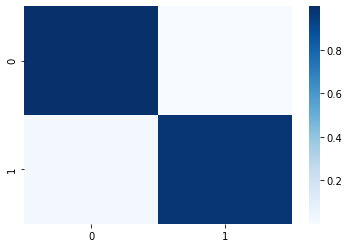

[[248494     30]
 [    32   1444]]
0.999752
0.9796472184531886
0.978319783197832


In [764]:
# This confusion matrix shows that there were only 62 misdclassifications out of 250,000 test cases.

score = model.evaluate(X_test, y_test, batch_size = 1000)
preds = [round(x[0]) for x in model.predict(X_test)] #model.predict(X_test)

conf_mat = confusion_matrix(y_test.to_list(), preds)
normalized_cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, cmap = 'Blues') # a heatmap normalized by  class
plt.show()
print(conf_mat)

print(accuracy_score(y_test, preds))
print(precision_score(y_test, preds))
print(recall_score(y_test, preds))

# Meme Classifier

Now that the model is trained, here I attempted to use it to distinguish different groups of memes. This was dont by iteratively asking the same question: "Are these two memes the same?". This worked okay but a lot of improvements can be made here. I tried other things such as DBSCAN and KNN but this method was much faster and gave better results. The really relevant code is in the "classify_memes" method. It's fairly straight-forward how it works.

In [709]:
class MemeClassifier():
    """ This is the class that manages multiple groups of memes. It keeps track of multiple instances of
        the MemeGroup class. This purpose of this class is to compare Memes and group them."""
    def __init__(self, memes, meme_groups = [], hash_size = 8, resized = True):
        self.memes = memes
        self.meme_groups = meme_groups or [MemeGroup([meme]) for meme in self.memes]
        self.hash_dict = self._build_hash_dict(hash_size, resized)
        self.max_classification_rounds = 10
        
    def _build_hash_dict(self, hash_size = 8, resized = True):
        print('initializing hash dictionary')
        meme_paths = {meme: os.path.join(os.getcwd(), 'IMAGES' + ('_RESIZED' if resized else ''), meme + '.jpg')
                      for meme in self.memes}
        hash_dict = {meme: imagehash.phash(Image.open(meme_paths[meme]), hash_size = hash_size) for meme in self.memes}
        
        print('Done')
        
        return hash_dict
            
        
    def save_classifications(self, path = 'meme_classifications.csv'):
        meme_dict = {'memes': {group.group_id: group.memes for group in self.meme_groups}}
        meme_df = pd.DataFrame.from_dict(meme_save).to_csv(path)
        
        print('Done')
        
    
    def load_classifications(self, path = 'meme_classification.txt'):
        # Might need to rework as UUIDs wont take into account UUIDs generated in previous instances.
        
        meme_dict = pd.read_csv(path).rename({'Unnamed: 0': 'id'}, axis = 1).to_dict(orient = 'index')
        
        for group in list(meme_dict.values())[:1]:
            mg = MemeGroup(memes = group['memes'], group_id = group['id'])
            self.meme_groups.append(mg)
        
        print('Done')
    
        
        
    def is_same_meme(self, meme_1, meme_2, prob = False):
        hash_1 = hash_dict[meme_1]
        hash_2 = hash_dict[meme_2]
        xnor = [1 if hash_1[i] == hash_2[i] else 0 for i in range(len(hash_1))]

        result = model.predict_proba(np.array([xnor]))[0][0] if prob else round(model.predict(np.array([xnor]))[0][0])

        return result
    
    def is_same_meme_group(self, group_x, group_y, evidence):
        
        min_evidence = min(len(group_x.memes), len(group_y.memes), evidence)
        rounds = 0
        num_pos = 0
        
        while rounds < min_evidence:
            if self.is_same_meme(np.random.choice(group_x.memes), np.random.choice(group_y.memes)):
                num_pos += 1
                
            rounds += 1
            
        return num_pos == min_evidence
    
    
    def merge_groups(self, group_ids):
        groups = [group for group in self.meme_groups if group.group_id in group_ids]
        new_memes = [meme for group in groups for meme in group.memes]
        new_clustering_rounds = max([group.clustering_rounds for group in groups])
        
        new_group = MemeGroup(memes = new_memes, clustering_rounds = new_clustering_rounds)
        
        for group in groups:
            self.meme_groups.remove(group)
            del(group)
            
        self.meme_groups.append(new_group)
        
        
        
    def classify_memes(self, min_group_size = 10, evidence = 5):
        # Evidence is the number of memes, meme_y, in a group that some meme, meme_x must be "the same meme" with
        # in order to be accepted into the group. In reality evidence can't be larger than the group size.
        rounds = 0 # The number of times the algorithm has passsed through every meme
        num_previous_groups = np.inf # Number of groups in last pass. If this is the same twice, then break
        num_current_groups = len(self.meme_groups)
        
        while (any([1 for group in self.meme_groups if group.size < min_group_size]) and 
               rounds < self.max_classification_rounds and
               num_previous_groups > num_current_groups):
            
            for group_x in self.meme_groups:
                groups_to_merge = []

                for group_y in self.meme_groups: 
                    if group_y != group_x:
                        if self.is_same_meme_group(group_x, group_y, evidence):
                            groups_to_merge.append(group_y.group_id)


                if groups_to_merge:
                    self.merge_groups(groups_to_merge + [group_x.group_id])
                
            print(f'Classified memes into {len(self.meme_groups)} categories.' + 
                  (' Reitterating.' if min([group.size for group in self.meme_groups]) < min_group_size else ''))
            
            rounds += 1
            num_previous_groups = num_current_groups
            num_current_groups = len(self.meme_groups)
            
                
        print('Done')

In [710]:
class MemeGroup():
    """ This is the class that every group of memes takes on. The group has an ID, size, etc. The meme_id's found in
        the dataframe are what is stored in the memes attribute."""
    def __init__(self, memes = [], group_id = None, clustering_rounds = 0):
        self.memes = memes
        self.size = len(memes)
        self.clustering_rounds = clustering_rounds
        self.group_id = group_id or str(uuid.uuid1())

In [737]:
# Create a list of 50 meme groups with a high number of samples in the dataframe
random_20_memes = df.groupby('template').size().sort_values(ascending = False)[:100].sample(20).index
meme_ids = df.loc[df['template'].isin(random_20_memes), 'meme_id']

In [755]:
# This is how many memes are in the 20 given meme groups to be classified.
print(len(meme_ids))

21485


In [738]:
# initialize a classifier on all of the unique meme id's in our dataframe (170,000 + of them)
mc = MemeClassifier(memes = meme_ids)

initializing hash dictionary
Done


In [739]:
#runtime: 16 hours on full dataframe
t1 = datetime.utcnow()
mc.classify_memes(min_group_size = 5, evidence = 5)
t2 = datetime.utcnow()

print((t2 - t1).seconds)

Classified memes into 134 categories. Reitterating.
Classified memes into 86 categories. Reitterating.
Classified memes into 80 categories. Reitterating.
Classified memes into 73 categories. Reitterating.
Classified memes into 72 categories. Reitterating.
Classified memes into 69 categories. Reitterating.
Classified memes into 68 categories. Reitterating.
Classified memes into 67 categories. Reitterating.
Classified memes into 66 categories. Reitterating.
Classified memes into 66 categories. Reitterating.
Done
590


In [745]:
# this is are the set versions of the meme gorups
[{meme_temps[meme] for meme in group.memes} for group in mc.meme_groups]

# If you want to see the actual group distributions, then uncomment and run this. Its 20,000 entries.
# sorted([[meme_temps[meme] for meme in group.memes] for group in mc.meme_groups], key = lambda x: -len(x))

[{'Ron Paul'},
 {'Ron Paul'},
 {'Ron Paul'},
 {'Ron Paul'},
 {'One Does Not Simply'},
 {'Scumbag Genetics'},
 {'Ron Paul'},
 {'Ron Paul'},
 {'Bad Luck Brian'},
 {'Bad Luck Brian'},
 {'Scumbag Genetics'},
 {'Scumbag Redditor'},
 {'Annoyed Picard'},
 {'Scumbag Teacher'},
 {'Scumbag Teacher'},
 {'Annoyed Picard'},
 {'Push it somewhere else Patrick'},
 {'1990s Problems'},
 {'1990s Problems'},
 {'skeptical baby'},
 {'Ron Paul'},
 {'Scumbag Redditor'},
 {'Pickup-Line Panda', 'Ridiculously photogenic guy'},
 {'Bad Joke Eel'},
 {'Scumbag Brain'},
 {'Scumbag Redditor'},
 {'1990s Problems', 'Bad Luck Brian'},
 {'Annoyed Picard'},
 {'skeptical baby'},
 {'Ron Paul'},
 {'Almost Politically Correct Redneck', 'Annoyed Picard'},
 {'1990s Problems'},
 {'Almost Politically Correct Redneck', 'Annoyed Picard'},
 {'Ron Paul'},
 {'Annoyed Picard', 'Bad Joke Eel'},
 {'Bad Luck Brian'},
 {'Bad Luck Brian'},
 {'Socially Awkward Awesome Penguin'},
 {'skeptical baby'},
 {'Captain Hindsight', 'Scumbag Redditor'},

In [746]:
classification_scores = dict()

for meme_group in [x for x in mc.meme_groups if len(x.memes) > 5]:
    templates = [meme_temps[x] for x in meme_group.memes]
    group_mode = max(templates, key = templates.count)
    score = templates.count(group_mode) / len(templates)
    
    classification_scores[meme_group.group_id] = score

In [747]:
# This is the average "purity" of each meme group
np.mean(list(classification_scores.values()))

0.9617572519411453

# Conclusion

The model works fairly well at distinguishing memes. It outperformed other models I attemped such as gradient boosting trees and logistic regression. In terms of speed, it is only slightly slower than logistic regression, the fastest model. It can do so with ~98% precision and ~98% recall on randomly selected pairs of memes in the dataframe. 

The model's performance can probably be improved. In fact, the model returned "false positives" on memes that were allegedly different such as "Annoyed Picard HD" and "Annoyed Picard". Obviously, the memes are actually the same and our model was actually correct. This revealed to me that many of the memes in the dataset were mislabeled. This made the project even harder to move forward with as I spent a good amount of time veryfying the labels in the dataframe and suspect that there are still mistakes in it.

However, I didn't have as much time to improve the clustering method (MemeClassifier). I tried to use other methods to cluster the memes such as DBSCAN but speed was a large issue in both testing methods and running them in full. For instance, a full classification of all 170,000+ memes in the dataframe took about 17 hours to complete.